In [1]:
%load_ext autoreload
%autoreload 2
import os
import json
import numpy as np
import pandas as pd
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

MPL_CUSTOM = {
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'figure.dpi': 120,
    'figure.figsize': (4, 3.5),
    'figure.facecolor': 'white',
    'xtick.top': True,
    'xtick.direction': 'in',
    'xtick.minor.visible': True,
    'ytick.right': True,
    'ytick.direction': 'in',
    'ytick.minor.visible': True,
}

for k, v in MPL_CUSTOM.items():
    mpl.rcParams[k] = v

In [2]:
current_dir = Path(os.getcwd())
project_dir = current_dir.parent.parent.absolute()

## Key notes
--------------------------------------------
- to restore $S(r)$ from noisy data $C(q)$, standard RL algorithm is bound to fail as it overfits the noise. 
- to demonstrate the process of deblurring, we consider toy model
    - the truth is generated with gaussian $S(r)$ with **fine-binned** kernel since only continuous quantities simulate realistic data
    - **coarse-binned** kernel is used in RL to avoid overfitting (requirement of RL)

    

### 0. generate truth
-------------------------

In [3]:
def gaus_source(r, R, lambda_=1.):
    return lambda_ / (2 * np.sqrt(np.pi) * R)**3 * np.exp(-r**2 / 4 / R**2)

R_true = 3.5
lambda_true = 0.8

In [4]:
# kernel fine-binned in r
q_fine, r_fine, kernel_fine = np.load(str(project_dir / 'database/kernel/pp/4mev.npz')).values()
source_truth = gaus_source(r_fine, R_true, lambda_true)
K_fine = 4 * np.pi * (kernel_fine+1/lambda_true) * r_fine**2 * (r_fine[1]-r_fine[0])
correlation_truth = np.dot(K_fine, source_truth)

### 1. construct coarse-binned kernel
-----------------------------------------
To choose the binning in `r`, we need to consider
- away from origin due to the $r^2$ dependence in the Koonin-Pratt equation
- the associated correlation function calculated with finite sum is consistent with the truth

In [5]:
q, r, dr, kernel = np.load(str(project_dir / 'database/kernel/pp/custom.npz')).values()
K = 4 * np.pi * (kernel+1/lambda_true) * r**2 * dr
source_coarse = gaus_source(r, R_true, lambda_true)
correlation_coarse = np.dot(K, source_coarse)

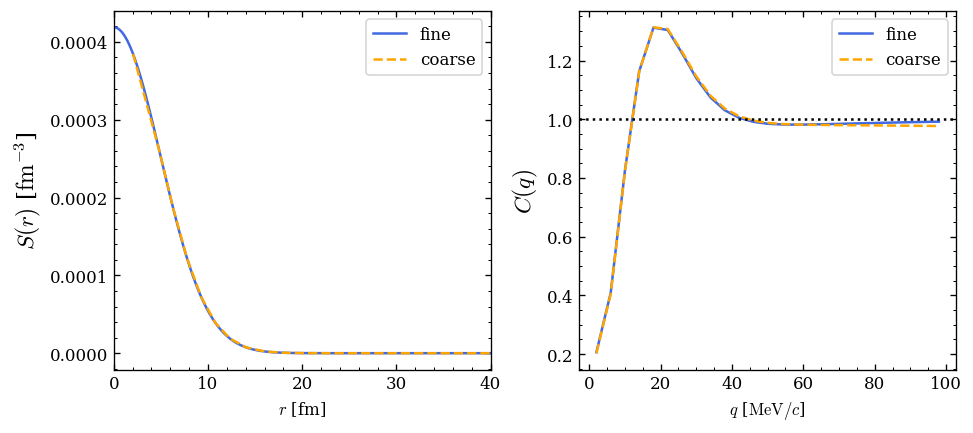

In [6]:
fig, axes = plt.subplots(1,2,figsize=(8,3.5),constrained_layout=True,dpi=120)

axes[0].plot(r_fine, source_truth, label='fine', color='royalblue')
axes[0].plot(r, source_coarse, label='coarse', ls='--', color='orange')
axes[1].plot(q_fine, correlation_truth, label='fine', color='royalblue')
axes[1].plot(q, correlation_coarse, label='coarse', ls='--', color='orange')
axes[1].axhline(1, color='k', ls=':')

axes[0].set_xlim(0,40)
axes[0].set_xlabel(r'$r$ [fm]')
axes[0].set_ylabel(r'$S(r)$ [$\mathrm{fm}^{-3}$]', fontsize=14)
axes[1].set_xlabel(r'$q$ [$\mathrm{MeV}/c$]')
axes[1].set_ylabel(r'$C(q)$', fontsize=14)

for ax in axes:
    ax.legend()

plt.show()

## remarks
--------------
- the resulting correlation deviates from the truth generated with fine-binned kernel, especially at large q. However, it should show little effect on deblurring since the tail is mostly flat and the error in this region is essentially small. An improvement would be to consider trapezoidal rule when construct the $\mathcal{K}$ matrix.
- the resulting correlation is consistent with the truth for all reasonable values of parameter `R_true`, `lambda_true`.
- if an unrealistic source such as an exponential function is used, the above agreement would be lost.

## Load realistic data
----------------------------------------
The previous part describes the choice in binning the kernel. Here, we pre-construct the correlation function with the same parameter and perturb the resulting correlation function according to experimental errorbars, i.e.

$$ C \sim \mathcal{N}(C, \delta C)$$


In [7]:
data_dir = project_dir / 'database/cf/pp/gaussian'
truth = pd.read_csv(data_dir / 'true.csv')
blurred = pd.read_csv(data_dir / 'blurred.csv')
blurred.query('y != 0 & yerr > 0', inplace=True)
q_indices = np.digitize(blurred.x.values, q, right=True)

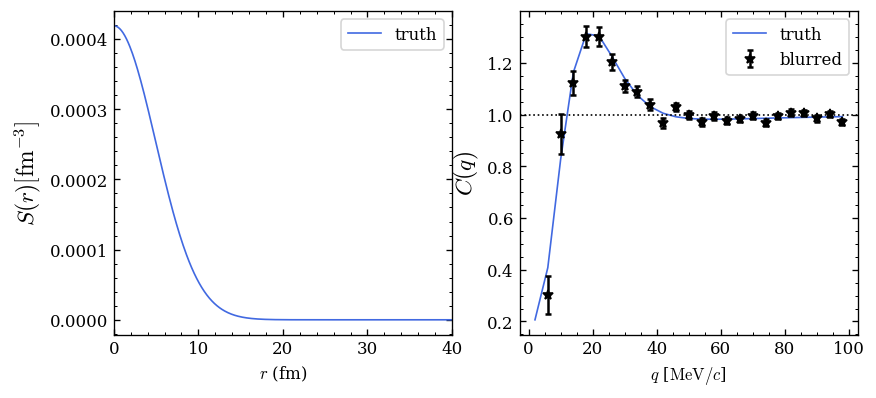

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

axes[0].plot(r_fine, source_truth, label='truth', lw=1, color='royalblue')
axes[1].plot(truth.x.values, truth.y.values, label='truth', lw=1, color='royalblue')
axes[1].errorbar(
    blurred.x.values, blurred.y.values, yerr=blurred.yerr.values, label='blurred', marker='*', color='k',
    capsize=2, capthick=1.5, ls='none'
)

axes[0].set_xlim(0, 40)
axes[1].axhline(1, color='k', ls=':', lw=1)

for ax in axes:
    ax.legend()

axes[0].set_xlabel(r'$r$ (fm)')
axes[1].set_xlabel(r'$q$ [$\mathrm{MeV}/c$]')
axes[0].set_ylabel(r'$S(r) [\mathrm{fm}^{-3}]$', fontsize=14)
axes[1].set_ylabel(r'$C(q)$', fontsize=14)
plt.show()

## Deblurr with total variation regularization
-----------------------------------------------

Effectively, the RL algorithm is modified as
$$
    \mathcal{S}_i^{(r+1)} = \mathcal{S}_i^{(r)} I^{(r)}_i \sum_j \dfrac{\tilde{\mathcal{C}}_j}{\mathcal{C}_j^{(r)}} \mathcal{K}_{ji}
$$ 

Total variation regularization refes to the multiplicative term $I$ which smoothens the solution, is defined through

\begin{gather*}
    I^{(r)}_i = 1 - \lambda \mathbf{\nabla}\cdot \bigg(\dfrac{\mathbf{\nabla} S_i^{(r)}}{|\mathbf{\nabla} S_i^{(r)}|}\bigg)
\end{gather*}

In 1D, the regularization factor reduces to 

\begin{gather*}
    I^{(r)}_i = 
    \begin{dcases}
        1 - \lambda \text{   if $S_i^{r} < S_{i-1, r+1}^{r}$} \\
        1 + \lambda \text{   if $S_i^{r} > S_{i-1, r+1}^{r}$} \\
        1  \qquad \text{otherwise}
    \end{dcases}
\end{gather*}

In [9]:
def richardson_lucy_tv(niter, X, y, psf, accel=1.0, return_all=False, lambda_tv=0.000):
    y_norm = np.sum(y)
    psf_norm = np.sum(psf, axis=0)

    psf_ = psf / psf_norm
    img = y / y_norm
    deconv = X / np.sum(X)
    conv = np.dot(psf_, deconv) + 1e-12

    X_preds = []
    y_preds = []

    for i_ in range(niter):
        
        # implement TV regularization
        # image is not considered circular for now
        reg_factor = np.ones_like(deconv)
        for i in range(1, len(deconv) - 1):
            if (deconv[i] < deconv[i-1]) and (deconv[i] < deconv[i+1]):
                reg_factor[i] = 1. / (1 - lambda_tv)
            elif (deconv[i] > deconv[i-1]) and (deconv[i] > deconv[i+1]):
                reg_factor[i] = 1. / (1 + lambda_tv)

        deconv = deconv * (np.einsum('i,ij', img / conv, psf_)) ** accel * reg_factor

        # explicitly re-normalize
        if lambda_tv > 0:
            deconv /= np.sum(deconv)

        conv = np.dot(psf_, deconv) + 1e-12

        X_preds.append(deconv * y_norm / psf_norm)
        y_preds.append(conv * y_norm)
        
    if return_all:
        return X_preds, y_preds
    
    return X_preds[-1], y_preds[-1]

In [10]:
lambda_guess = 0.80

In [11]:
flat_guess = np.ones_like(r)
flat_guess /= np.sum(flat_guess * 4 * np.pi * r**2 * dr)
flat_guess *= lambda_guess

In [12]:
K = 4 * np.pi * (kernel + 1./ lambda_guess) * r ** 2 * dr

In [13]:
niter = 10000
restored_list, predicted_list = richardson_lucy_tv(
    niter = niter, 
    X = flat_guess,
    y = blurred.y.values,
    psf = K[q_indices,:],
    return_all = True,
    accel = 1.99,
    lambda_tv = 0.001
)

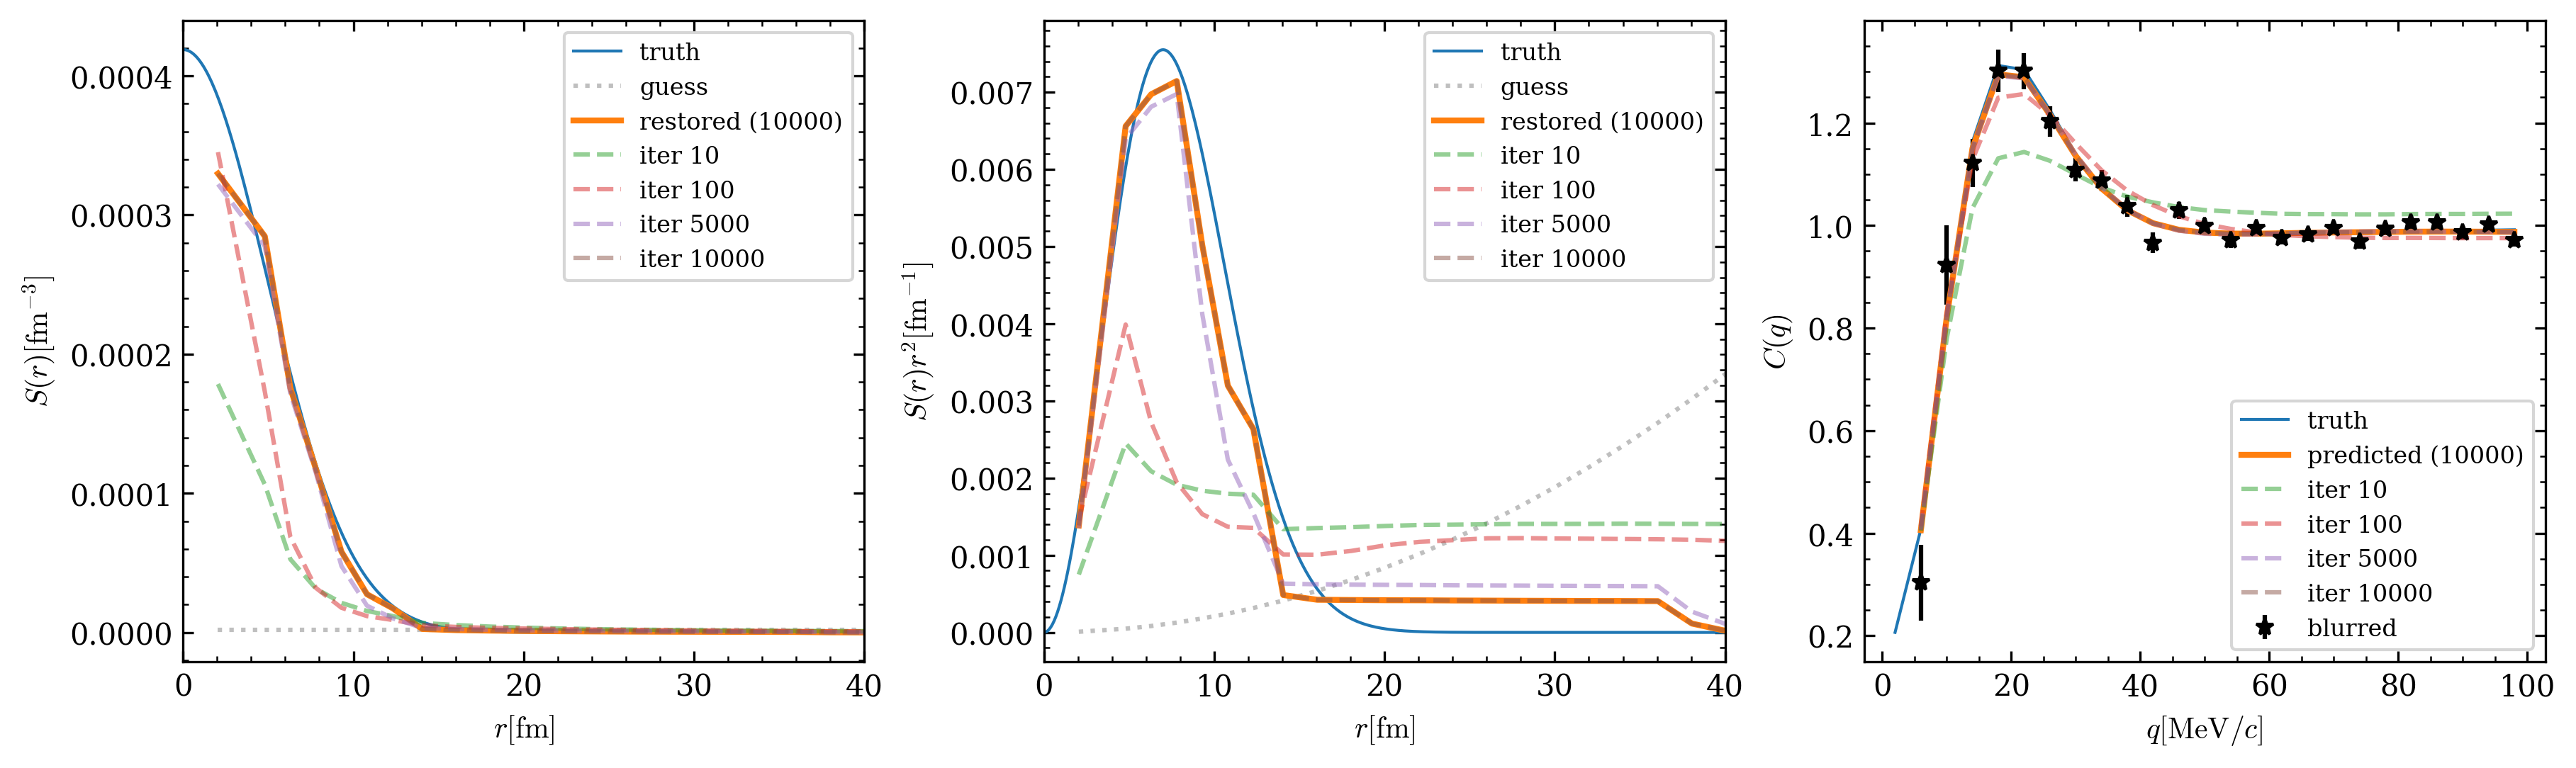

In [24]:
fig, axes = plt.subplots(1,3,figsize=(12,3.5),constrained_layout=True,dpi=300)

axes[0].plot(r_fine, source_truth , label='truth', lw=1)
axes[0].plot(r, flat_guess, label='guess', ls=':', color='gray', alpha=0.5)
axes[0].plot(r, restored_list[-1], label=f'restored ({niter:0d})', ls='-', lw=2)
axes[1].plot(r_fine, source_truth * r_fine**2 , label='truth', lw=1)
axes[1].plot(r, flat_guess * r**2, label='guess', ls=':', color='gray', alpha=0.5)
axes[1].plot(r, restored_list[-1] * r**2, label=f'restored ({niter:0d})', ls='-', lw=2)
axes[2].plot(q, correlation_truth, label='truth', lw=1)
axes[2].errorbar(
    blurred.x.values, blurred.y.values, yerr=blurred.yerr.values, 
    label='blurred', marker='*', color='k', ls='none'
)
axes[2].plot(blurred.x.values, predicted_list[-1], label=f'predicted ({niter:0d})', ls='-', lw=2)

for i, epoch in enumerate([10, 100, 5000, 10000, 100000]):
    if epoch > niter:
        continue
    axes[0].plot(r, restored_list[epoch - 1], ls='--', label=f'iter {epoch}', alpha=0.5)
    axes[1].plot(r, restored_list[epoch - 1] * r**2, ls='--', label=f'iter {epoch}', alpha=0.5)
    axes[2].plot(blurred.x.values, predicted_list[epoch - 1], ls='--', label=f'iter {epoch}', alpha=0.5)

axes[0].set_xlim(0, 40)
axes[0].set_xlabel(r'$r [\mathrm{fm}]$')
axes[0].set_ylabel(r'$S(r)  [\mathrm{fm}^{-3}]$')

axes[1].set_xlim(0, 40)
axes[1].set_xlabel(r'$r [\mathrm{fm}]$')
axes[1].set_ylabel(r'$S(r) r^2 [\mathrm{fm}^{-1}]$')

axes[2].set_xlabel(r'$q [\mathrm{MeV}/c]$')
axes[2].set_ylabel(r'$C(q)$')

axes[0].legend(loc='upper right', fontsize=8)
axes[1].legend(loc='upper right', fontsize=8)
axes[2].legend(loc='lower right', fontsize=8)

plt.show()